In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['XLA_FLAGS'] = "--xla_disable_hlo_passes=constant_folding"
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jaxquantum.codes as jqtb
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import numpy as np
from jax_tqdm import scan_tqdm
from jaxopt import GaussNewton, BFGS
plt.style.use('ggplot')

/home/rolleri/.conda/envs/jax-sims/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def exponential(x, x_data):
        return (x[2]+x[0]*jnp.exp(x[1]*x_data))
    
def fit_t1(times, amps, guess):
    gn = GaussNewton(residual_fun=lambda x, x_data, y_data: y_data-exponential(x, x_data), tol=1e-9, maxiter=100000)
    gn_sol = gn.run(guess, x_data=times, y_data=amps)
    return gn_sol.params, gn_sol.state.error

In [4]:
def modulated_exponential(x, x_data):
        return x[3] + x[0]*jnp.real(jnp.exp(x[1]*x_data + 1.j*x[2]*x_data))
    
def fit_t2(times, amps, guess):
    gn = GaussNewton(residual_fun=lambda x, x_data, y_data: y_data-modulated_exponential(x, x_data), tol=1e-9, maxiter=100000)
    gn_sol = gn.run(guess, x_data=times, y_data=amps)
    return gn_sol.params, gn_sol.state.error, gn_sol

In [5]:
N = 2

initial_state = jqt.basis(2, 1) ^ jqt.basis(N, 1)

In [86]:
omega_qb = 0*90e-3*2*jnp.pi
#omega_res = 0*4.18*2*jnp.pi
omega_res = 0.2e-3*2*jnp.pi
chi_e = 17.41e-6*2*jnp.pi
chi_g = -16.93e-6*2*jnp.pi
chi = chi_e-chi_g
gamma_res_T1 = 1/(27.5e3)
gamma_res_Tphi = 1/(1e9)
gamma_qb_T1 = 1/(150e3)
gamma_qb_Tphi = 1/(28e3)
t_sim = 200e3

In [87]:
freq_res = 4.18e9
freq_qb = 90e6
k_B = 1.380649e-23
h = 6.62607015e-34
T_res = 40e-3
T_qb = 40e-3
n_bar_qb = 1/(jnp.exp(h*freq_qb/k_B/T_qb)-1)
n_bar_res = 1/(jnp.exp(h*freq_res/k_B/T_res)-1)

In [88]:
H = (omega_qb * (jqt.sigmaz() ^ jqt.identity(N)) +
    omega_res * (jqt.identity(2) ^ jqt.num(N)) +
    (chi_e-chi_g) * (jqt.sigmaz() ^ jqt.num(N))/2)
    # chi_e * ((jqt.basis(2, 1) @ jqt.basis(2, 1).dag()) ^ jqt.num(N)) +
    # chi_g * ((jqt.basis(2, 0) @ jqt.basis(2, 0).dag()) ^ jqt.num(N)))

In [141]:
L_res_T1 = jnp.sqrt(gamma_res_T1) * (jqt.identity(2) ^ jqt.destroy(N))
L_res_Tphi = jnp.sqrt(gamma_res_Tphi) * (jqt.identity(2) ^ jqt.num(N))
L_qb_T1_loss = jnp.sqrt(2*gamma_qb_T1) * ((jqt.basis(2, 0) @ jqt.basis(2, 1).dag()) ^ jqt.identity(N))
L_qb_T1_gain = jnp.sqrt(2*gamma_qb_T1) * ((jqt.basis(2, 1) @ jqt.basis(2, 0).dag()) ^ jqt.identity(N))
L_qb_Tphi = jnp.sqrt(gamma_qb_Tphi) * (jqt.sigmaz() ^ jqt.identity(N))
Ls = jqt.Qarray.from_list([L_res_T1, L_res_Tphi, L_qb_T1_loss, L_qb_T1_gain, L_qb_Tphi])

In [142]:
tlist = jnp.linspace(0, t_sim, 900)

In [143]:
result = jqt.mesolve(H=H,
                     rho0=initial_state,
                     tlist=tlist,
                     c_ops=Ls,
                    )

100% |████████████████████████████████████████████████████████████████████████████████████████| [00:00<00:00, 239.94%/s]


In [144]:
sigma_z = jqt.overlap(result.ptrace(0), jqt.sigmaz())

In [145]:
fit_res = fit_t1(tlist, sigma_z, jnp.array([-1., -1/150e3, 0.1]))
t1 = -1/fit_res[0][1]

/home/rolleri/.conda/envs/jax-sims/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/rolleri/.conda/envs/jax-sims/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


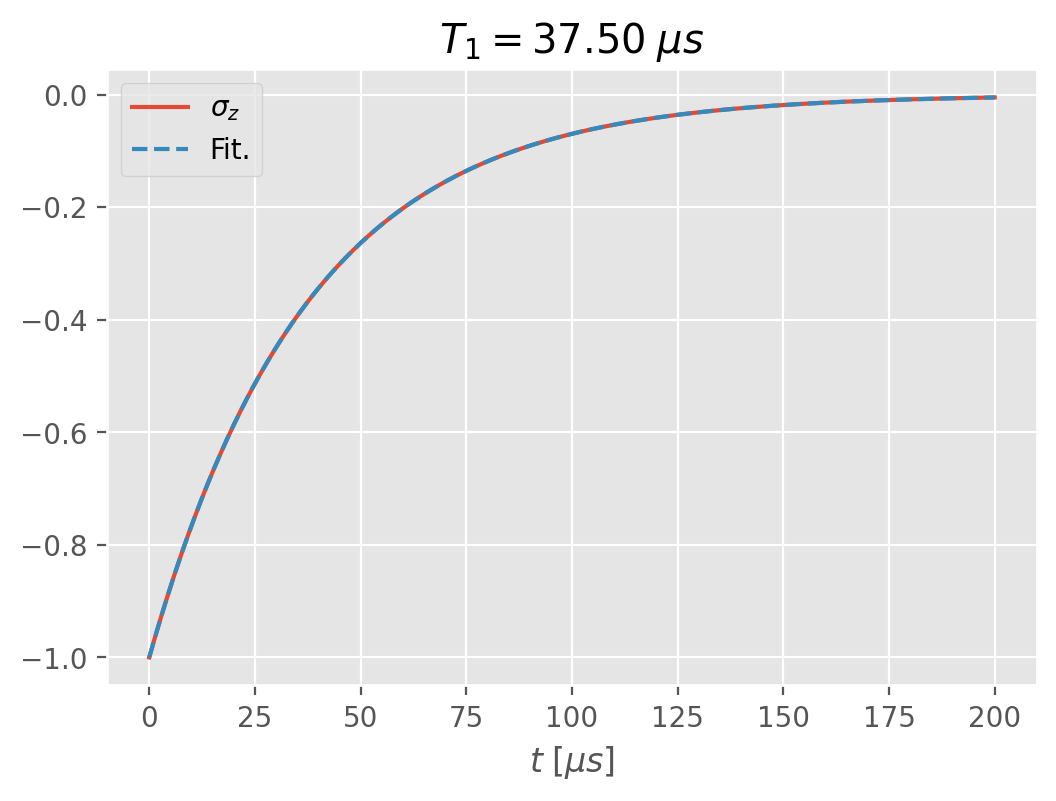

In [146]:
fig, ax = plt.subplots(1, figsize=(6, 4), dpi=200)
ax.plot(tlist/1e3, sigma_z, label="$\\sigma_z$")
ax.plot(tlist/1e3, exponential(fit_res[0], tlist), label="Fit.", ls="--")
ax.set_xlabel("$t \;[\\mu s]$")
ax.set_title(f"$T_1={t1/1e3:.2f}\; \\mu s$")
ax.legend()

In [147]:
pop_fock_0 = jqt.overlap(result.ptrace(1), jqt.basis(N, 0) @ jqt.basis(N, 0).dag())
pop_fock_1 = jqt.overlap(result.ptrace(1), jqt.basis(N, 1) @ jqt.basis(N, 1).dag())


In [148]:
fit_res = fit_t1(tlist, pop_fock_1, jnp.array([1., -1/30e3, 0]))
t1 = -1/fit_res[0][1]

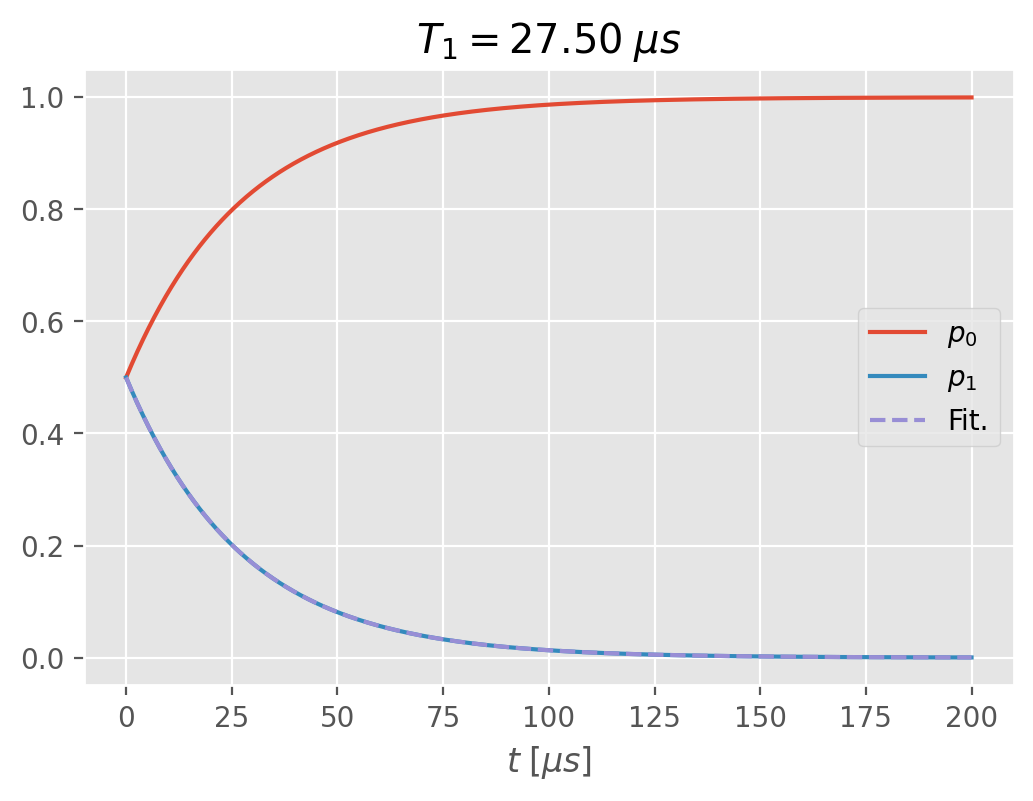

In [149]:
fig, ax = plt.subplots(1, figsize=(6, 4), dpi=200)
ax.plot(tlist/1e3, pop_fock_0, label="$p_0$")
ax.plot(tlist/1e3, pop_fock_1, label="$p_1$")
ax.plot(tlist/1e3, exponential(fit_res[0], tlist), label="Fit.", ls="--")
ax.set_xlabel("$t \;[\\mu s]$")
ax.set_title(f"$T_1={t1/1e3:.2f}\; \\mu s$")
ax.legend()

In [150]:
initial_state = jqt.basis(2, 1) ^ (jqt.basis(N, 0) + jqt.basis(N, 1)).unit()
solver_options = jqt.core.solvers.SolverOptions.create(max_steps=10_000_000, solver="Dopri8")

In [151]:
result = jqt.mesolve(H=H,
                     rho0=initial_state,
                     tlist=tlist,
                     c_ops=Ls,
                     solver_options=solver_options,
                    )

100% |████████████████████████████████████████████████████████████████████████████████████████| [00:00<00:00, 535.68%/s]


In [152]:
pop_fock_0 = jqt.overlap(result.ptrace(1), jqt.basis(N, 0) @ jqt.basis(N, 0).dag())
pop_fock_1 = jqt.overlap(result.ptrace(1), jqt.basis(N, 1) @ jqt.basis(N, 1).dag())

In [153]:
fit_res = fit_t1(tlist, pop_fock_1, jnp.array([.5, -1/30e3]))
t1 = -1/fit_res[0][1]

In [154]:
fit_res

(Array([ 5.00000000e-01, -3.63531216e-05], dtype=float64),
 Array(8.00818452e-10, dtype=float64))

/home/rolleri/.conda/envs/jax-sims/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/rolleri/.conda/envs/jax-sims/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


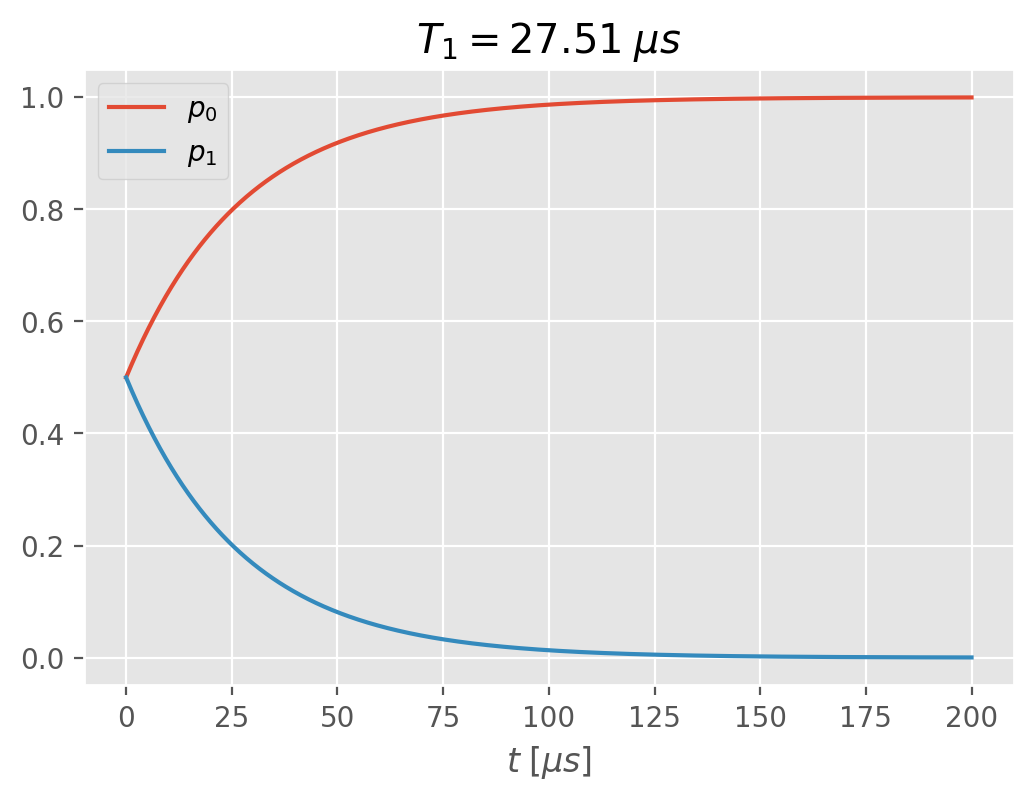

In [155]:
fig, ax = plt.subplots(1, figsize=(6, 4), dpi=200)
ax.plot(tlist/1e3, pop_fock_0, label="$p_0$")
ax.plot(tlist/1e3, pop_fock_1, label="$p_1$")
ax.set_xlabel("$t \;[\\mu s]$")
ax.set_title(f"$T_1={t1/1e3:.2f}\; \\mu s$")
ax.legend()

In [156]:
phase_fock_01 = jnp.real(jqt.overlap(result.ptrace(1), jqt.basis(N, 1) @ jqt.basis(N, 0).dag()+jqt.basis(N, 0) @ jqt.basis(N, 1).dag()))

In [157]:
fit_res, error, state = fit_t2(tlist, phase_fock_01, jnp.array([1, -1/25e3, 2*0.63e-3, 0]))
t2 = -1/fit_res[1]
mod_freq = fit_res[2]

In [158]:
mod_freq

Array(0.00115169, dtype=float64)

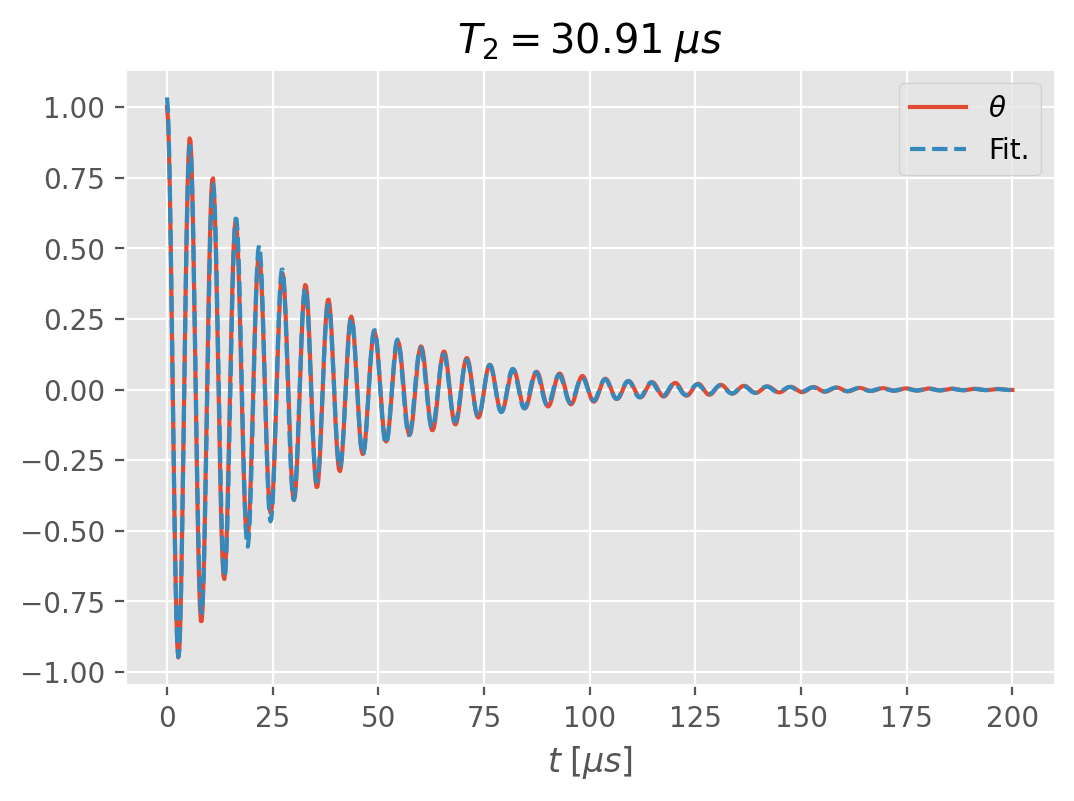

In [159]:
fig, ax = plt.subplots(1, figsize=(6, 4), dpi=200)
ax.plot(tlist/1e3, phase_fock_01, label="$\\theta$")
ax.plot(tlist/1e3, modulated_exponential(fit_res, tlist), label="Fit.", ls="--")
ax.set_xlabel("$t \;[\\mu s]$")
ax.set_title(f"$T_2={t2/1e3:.2f}\; \\mu s$")
ax.legend()

In [170]:
gamma_phi_analytic = 4*((chi)**2)/gamma_qb_T1/(1+(2*(chi)/gamma_qb_T1)**2)

In [171]:
1/gamma_phi_analytic

150035.80044551828

In [166]:
gamma_2_analytic = 0.5 * gamma_res_T1 + gamma_phi_analytic

In [167]:
1/gamma_2_analytic

31743.578311655434

In [169]:
1+(2*(chi)/2/gamma_qb_T1)**2

1048.4729980913125

In [174]:
gamma_phi = 1/t2 - 0.5 * gamma_res_T1

In [175]:
gamma_phi

Array(1.41693833e-05, dtype=float64)